In [1]:
from tabula import read_pdf
import pandas as pd
import datetime
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
d = read_pdf('../data/ridehistory.pdf', pandas_options={'header':1}, pages = 'all')

In [3]:
d = d.drop(['ROUTE', 'DEBIT', 'CREDIT', 'BALANCE*'], axis=1)

In [4]:
d = d.dropna()

In [5]:
new_cols = ['date_time']
new_cols.extend(d.columns[1:])

In [6]:
d.columns = new_cols

In [7]:
d.loc[:, 'f_date_time'] = [datetime.datetime.strptime(dt, "%m/%d/%Y %I:%M %p") for dt in d.date_time.values]

In [8]:
d.loc[:, 'am_pm'] = [dt[-2:] for dt in d.date_time.values]

In [9]:
d = d.reset_index(drop=True)

In [10]:
(d.f_date_time.values[1] - d.f_date_time.values[0])/np.timedelta64(1, 'm')

43.0

In [11]:
i = 1
diff = [None]
origin = [None]

while i < d.shape[0]:
    if d.loc[i, 'TRANSACTION TYPE'][-7:] == 'payment' and d.loc[i-1, 'TRANSACTION TYPE'][-9:] == 'deduction':
        diff.append((d.f_date_time.values[i] - d.f_date_time.values[i - 1])/np.timedelta64(1, 'm'))
        origin.append(d.LOCATION[i-1])
        i +=1
    else:
        diff.append(None)
        origin.append(None)
        i += 1

In [12]:
d.loc[:, 'ride_length'] = diff
d.loc[:, 'origin'] = origin

In [13]:
d = d[d.loc[:, 'TRANSACTION TYPE']!= 'Single-tag fare payment']

In [14]:
d = d[d.loc[:, 'TRANSACTION TYPE'] != 'Remote re-load of existing purse']

In [15]:
d = d.reset_index(drop=True)

In [17]:
# LOCATION indicates where I exited, this table
d.pivot_table(values='ride_length', index = ['am_pm', 'LOCATION'], aggfunc=['mean', 'median', np.std, 'min', 'max', 'count'])

mean      median         std  \
                                  ride_length ride_length ride_length   
am_pm LOCATION                                                          
AM    Downtown Berkeley             19.000000        19.0         NaN   
      El Cerrito Del Norte (BART)   13.000000        13.0         NaN   
      El Cerrito Plaza              10.000000        10.0         NaN   
      Embarcadero (BART)            44.628571        44.0    5.391091   
      Richmond                      15.000000        15.0         NaN   
PM    Civic Center (BART)                 NaN         NaN         NaN   
      Downtown Berkeley                   NaN         NaN         NaN   
      El Cerrito Del Norte (BART)   44.463415        45.0   14.263761   
      El Cerrito Plaza              43.000000        43.0    7.071068   
      Embarcadero (BART)            39.000000        39.0         NaN   
      Lake Merritt (BART)           35.000000        35.0         NaN   
      Montgomery (BART)             51.000000        51.0         NaN   
      North Berkeley                      NaN         NaN         NaN   
      OAC Coliseum                  39.000000        39.0         NaN   
      Oakland City Center 12th St   46.000000        46.0         NaN   
      Powell St (BART)                    NaN         NaN         NaN   
      Richmond                            NaN         NaN         NaN   

                                          min         max       count  
                                  ride_length ride_length ride_length  
am_pm LOCATION                                                         
AM    Downtown Berkeley                  19.0        19.0           1  
      El Cerrito Del Norte (BART)        13.0        13.0           1  
      El Cerrito Plaza                   10.0        10.0           1  
      Embarcadero (BART)                 34.0        63.0          35  
      Richmond                           15.0        15.0           1  
PM    Civic Center (BART)                 NaN         NaN           0  
      Downtown Berkeley                   NaN         NaN           0  
      El Cerrito Del Norte (BART)         6.0        79.0          41  
      El Cerrito Plaza                   38.0        48.0           2  
      Embarcadero (BART)                 39.0        39.0           1  
      Lake Merritt (BART)                35.0        35.0           1  
      Montgomery (BART)                  51.0        51.0           1  
      North Berkeley                      NaN         NaN           0  
      OAC Coliseum                       39.0        39.0           1  
      Oakland City Center 12th St        46.0        46.0           1  
      Powell St (BART)                    NaN         NaN           0  
      Richmond                            NaN         NaN           0

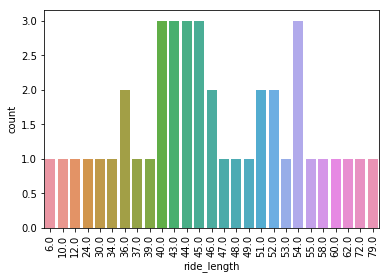

In [18]:
to_home_afternoon = [x and y for x, y in zip(d.LOCATION == 'El Cerrito Del Norte (BART)', d.am_pm == 'PM')]
sns.countplot(d.loc[to_home_afternoon, 'ride_length'])
plt.xticks(rotation = 90);

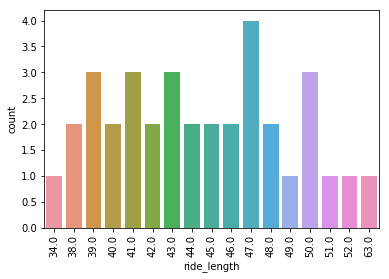

In [19]:
to_embarc_morning = [x and y for x, y in zip(d.LOCATION == 'Embarcadero (BART)', d.am_pm == 'AM')]
sns.countplot(d.loc[to_embarc_morning, 'ride_length'])
plt.xticks(rotation = 90);

In [20]:
# LOCATION indicates where I exited, this table
d.pivot_table(values='ride_length', index = ['origin', 'LOCATION'], aggfunc=['mean', 'median',np.std,'min', 'max', 'count'])

mean  \
                                                        ride_length   
origin                      LOCATION                                  
Civic Center (BART)         El Cerrito Del Norte (BART)   46.125000   
Downtown Berkeley           El Cerrito Del Norte (BART)   11.000000   
El Cerrito Del Norte (BART) Downtown Berkeley             19.000000   
                            El Cerrito Plaza              10.000000   
                            Embarcadero (BART)            44.472222   
                            Lake Merritt (BART)           35.000000   
                            Montgomery (BART)             51.000000   
                            OAC Coliseum                  39.000000   
                            Oakland City Center 12th St   46.000000   
                            Richmond                      15.000000   
El Cerrito Plaza            El Cerrito Del Norte (BART)    9.500000   
Embarcadero (BART)          El Cerrito Del Norte (BART)   49.769231   
                            El Cerrito Plaza              48.000000   
Lake Merritt (BART)         El Cerrito Del Norte (BART)   34.000000   
OAC Coliseum                El Cerrito Plaza              38.000000   
Oakland City Center 12th St El Cerrito Del Norte (BART)   30.000000   
Powell St (BART)            El Cerrito Del Norte (BART)   44.000000   
Richmond                    El Cerrito Del Norte (BART)   24.000000   

                                                             median  \
                                                        ride_length   
origin                      LOCATION                                  
Civic Center (BART)         El Cerrito Del Norte (BART)        45.0   
Downtown Berkeley           El Cerrito Del Norte (BART)        11.0   
El Cerrito Del Norte (BART) Downtown Berkeley                  19.0   
                            El Cerrito Plaza                   10.0   
                            Embarcadero (BART)                 44.0   
                            Lake Merritt (BART)                35.0   
                            Montgomery (BART)                  51.0   
                            OAC Coliseum                       39.0   
                            Oakland City Center 12th St        46.0   
                            Richmond                           15.0   
El Cerrito Plaza            El Cerrito Del Norte (BART)         9.5   
Embarcadero (BART)          El Cerrito Del Norte (BART)        48.5   
                            El Cerrito Plaza                   48.0   
Lake Merritt (BART)         El Cerrito Del Norte (BART)        34.0   
OAC Coliseum                El Cerrito Plaza                   38.0   
Oakland City Center 12th St El Cerrito Del Norte (BART)        30.0   
Powell St (BART)            El Cerrito Del Norte (BART)        44.0   
Richmond                    El Cerrito Del Norte (BART)        24.0   

                                                                std  \
                                                        ride_length   
origin                      LOCATION                                  
Civic Center (BART)         El Cerrito Del Norte (BART)    4.853202   
Downtown Berkeley           El Cerrito Del Norte (BART)    1.414214   
El Cerrito Del Norte (BART) Downtown Berkeley                   NaN   
                            El Cerrito Plaza                    NaN   
                            Embarcadero (BART)             5.395692   
                            Lake Merritt (BART)                 NaN   
                            Montgomery (BART)                   NaN   
                            OAC Coliseum                        NaN   
                            Oakland City Center 12th St         NaN   
                            Richmond                            NaN   
El Cerrito Plaza            El Cerrito Del Norte (BART)    4.949747   
Embarcadero (BART)          El Cerrito Del Norte (BART)   10.508312   
              

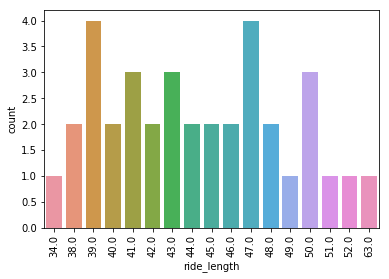

In [21]:
del_norte_to_embarc = [x and y for x, y in 
                       zip(d.origin=='El Cerrito Del Norte (BART)', d.LOCATION=='Embarcadero (BART)')]

sns.countplot(d.loc[del_norte_to_embarc, 'ride_length'])
plt.xticks(rotation = 90);

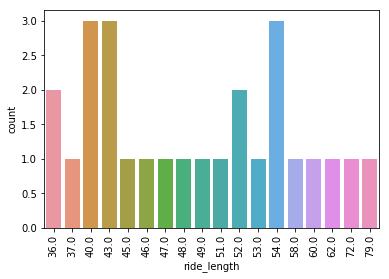

In [22]:
embarc_to_del_norte = [x and y for x, y in
                      zip(d.origin == 'Embarcadero (BART)', d.LOCATION == 'El Cerrito Del Norte (BART)')]

sns.countplot(d.loc[embarc_to_del_norte, 'ride_length'])
plt.xticks(rotation = 90);